In [ ]:
#Step1

In [23]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

dataframe = pd.read_csv("HistoricalData_1648610849582.csv")

#data_sp500 = pd,read_csv(" ")
print(dataframe)# Text file data converted to integer data type
#Shillerdataframe = pd.read_csv("S&P500 Schiller PE ratio.csv")
#print(Shillerdataframe)

            Date  Close/Last Volume     Open     High      Low
0     03/28/2022     4575.52     --  4541.09  4575.65  4517.69
1     03/25/2022     4543.06     --  4522.91  4546.03  4501.07
2     03/24/2022     4520.16     --  4469.98  4520.58  4465.17
3     03/23/2022     4456.24     --  4493.10  4501.07  4455.81
4     03/22/2022     4511.61     --  4469.10  4522.00  4469.10
...          ...         ...    ...      ...      ...      ...
2545  04/05/2012     1398.08     --  1398.79  1401.60  1392.92
2546  04/04/2012     1398.96     --  1413.09  1413.09  1394.09
2547  04/03/2012     1413.38     --  1418.98  1419.00  1404.62
2548  04/02/2012     1419.04     --  1408.47  1422.38  1404.46
2549  03/30/2012     1408.47     --  1403.31  1410.89  1401.42

[2550 rows x 6 columns]


In [20]:
# data_pe = pd.read_csv('S&P500 Schiller PE ratio.numbers')
# print(data_pe)

In [21]:
data_pe = pd.read_csv('S&P500 Schiller PE ratio.csv')
print(data_pe)

                 DateTime  SP500PERatio
0     1871-01-01 00:00:58         11.10
1     1871-02-01 00:00:58         11.25
2     1871-03-01 00:00:58         11.52
3     1871-04-01 00:00:58         11.85
4     1871-05-01 00:00:58         12.15
...                   ...           ...
1831        1/1/2022 0:00         26.08
1832     31-01-2022 00:00         25.75
1833        1/2/2022 0:00         26.16
1834     28-02-2022 00:00         24.94
1835        1/3/2022 0:00         24.56

[1836 rows x 2 columns]


In [22]:
date_pe = data_pe[["DateTime"]].to_numpy(dtype = "str")
date_sp = dataframe[["Date"]].to_numpy(dtype = "str")
# norm = MinMaxScaler(feature_range = (0, 1))
# trainData = norm.fit_transform(trainData)
# targetData = norm.fit_transform(targetData)
# trainData = np.flip(trainData)
# targetData = np.flip(targetData)
date_pe = np.flip(date_pe)
date_sp = np.flip(date_sp)
print(date_pe)
print(date_sp)

[['1/3/2022 0:00']
 ['28-02-2022 00:00']
 ['1/2/2022 0:00']
 ...
 ['1871-03-01 00:00:58']
 ['1871-02-01 00:00:58']
 ['1871-01-01 00:00:58']]
[['03/30/2012']
 ['04/02/2012']
 ['04/03/2012']
 ...
 ['03/24/2022']
 ['03/25/2022']
 ['03/28/2022']]


In [ ]:
#Step2 

In [38]:

ratio_sp = data_pe['SP500PERatio'].to_numpy(dtype = 'float')
mean_sp = ratio_sp.mean()
max_sp = ratio_sp.max()
median_sp = np.median(ratio_sp)#.median()
print(mean_sp)
print(max_sp)
print(median_sp)

sp_index = dataframe[["Close/Last", "Open"]].to_numpy(dtype = 'float')
print(sp_index.shape)
mean_sp_index = sp_index[:,0].mean()
mean_sp_index1 = sp_index[:,1].mean()

print(mean_sp_index)
print(mean_sp_index1)

16.126808278867102
123.73
14.955
(2550, 2)
2535.1493960784314
2510.4491058823533


In [ ]:
#step3
# Build the dataset  x: past 6 days  y: future 4 days

In [114]:
trainData = dataframe[["Close/Last", "Open",'High','Low']].to_numpy(dtype = 'float')
targetData = dataframe[["Close/Last"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)

dateAxis = []
for i in range(date.shape[0]):
    dateAxis.append(float(np.squeeze(date)[i][6:10]) + ( (float(np.squeeze(date)[i][0:2])-1)*30 + float(np.squeeze(date)[i][3:5]) )/366 )
dateAxis = np.array(dateAxis)

dateAxis=dateAxis[:-9]

print(dateAxis.shape)

(2541,)


In [115]:
X = []
Y = []
for i in range(trainData.shape[0] - 5 - 4):
    X.append(trainData[i:i+6])
    Y.append(targetData[i+6:i+6+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
Y.shape

(2541, 1, 4)

In [177]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

print(X.shape)
print(Y.shape)
print(dateAxis.shape)
print(len(X_test))
X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.3, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.3, shuffle=False)
print(len(X_test))
#print(date)
#print(X_test.size())
date_test=date[438:623,:]
print(X_fullTraining.shape)

(2541, 6, 4)
(2541, 1, 4)
(2541,)
0
763
(1778, 6, 4)


In [178]:
# Step3

In [179]:
import torch.functional as F
import pdb
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=20, kernel_size=5, stride=1)
        self.max_pool1 = nn.MaxPool1d(kernel_size=2, stride=1)
        self.ReLU = nn.ReLU()
        self.linear1 = nn.Linear(20*1, 4)
        
    def forward(self, x):
       
        x = x.permute(0, 2, 1) 
        x = self.conv1(x)
        
        x =  self.ReLU( self.max_pool1(x) ) 
        
        x = x.view(-1, 20*1)
        x = self.ReLU(self.linear1(x))
        x = x.unsqueeze(1)
        return x


class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.cnn = CNet()
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        
        self.fc = nn.Linear(hidden_dim, output_size)
        self.ReLU = nn.ReLU()
        
    
    def forward(self, x):
       
        x = self.cnn(x) 
        
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [ ]:
#Step4

In [180]:
RNN = Model(input_size=4, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (cnn): CNet(
    (conv1): Conv1d(4, 20, kernel_size=(5,), stride=(1,))
    (max_pool1): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (ReLU): ReLU()
    (linear1): Linear(in_features=20, out_features=4, bias=True)
  )
  (rnn): RNN(4, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
  (ReLU): ReLU()
)

In [181]:
xTensor = torch.from_numpy(X_fullTraining).float()
yTensor = torch.Tensor(Y_fullTraining).float()

for epoch in range(200):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100............. Loss: 0.040383122861385345
Epoch: 10/100............. Loss: 0.015571686439216137
Epoch: 20/100............. Loss: 0.014974013902246952
Epoch: 30/100............. Loss: 0.0141783831641078
Epoch: 40/100............. Loss: 0.011509901843965054
Epoch: 50/100............. Loss: 0.0028595777694135904
Epoch: 60/100............. Loss: 0.00029146907036192715
Epoch: 70/100............. Loss: 0.0005274754948914051
Epoch: 80/100............. Loss: 0.00022701735724695027
Epoch: 90/100............. Loss: 0.00013429374666884542
Epoch: 100/100............. Loss: 0.00010011404810938984
Epoch: 110/100............. Loss: 0.00010128617577720433
Epoch: 120/100............. Loss: 9.787978342501447e-05
Epoch: 130/100............. Loss: 9.654439054429531e-05
Epoch: 140/100............. Loss: 9.55337964114733e-05
Epoch: 150/100............. Loss: 0.0001614917127881199
Epoch: 160/100............. Loss: 9.431227954337373e-05
Epoch: 170/100............. Loss: 0.0001007548562483862
Epoch:

In [182]:
#Step5  loss and visualization

In [183]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred


def plotAccuracy(output_1,output_2,output_3,output_4,Y_main, date_pred ):
    
    table = []

    error_1 = prediction_error(output_1, Y_main)
    error_2 = prediction_error(output_2, Y_main)
    error_3 = prediction_error(output_3, Y_main)
    error_4 = prediction_error(output_4, Y_main)
    
    #error_dt = pd.DataFrame(data = error)
    #temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    #temp1 = np.array(temp1)

    fig = plt.figure(figsize=(9, 5))
    plt.title('Prediction Accuracy for Price P')
    plt.plot(date_pred, error_1, color = 'blue', label = 't+1')
    plt.plot(date_pred, error_2, color = 'green', label = 't+2')
    plt.plot(date_pred, error_2, color = 'purple', label = 't+3')
    plt.plot(date_pred, error_2, color = 'red', label = 't+4')
    plt.legend(loc="upper left")
    #plt.ylim(0,0.8)
    #plt.title('Date')
#     ax2.legend(loc="upper left")
    plt.show()

    




def plotNoiselessGraphs(output_1,output_2,output_3,output_4,Y_main,Y_plot,XAxis_date,date_pred,
    set1_title_1,set2_title_1,set3_title_1,set4_title_1,error_title):
    
    table = []

    error = prediction_error(output_1, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp1 = np.array(temp1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set1_title_1)
    ax1.plot(date_pred, output_1, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_2, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp2 = np.array(temp2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set2_title_1)
    ax1.plot(date_pred, output_2, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_3, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp3 = np.array(temp3)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set3_title_1)
    ax1.plot(date_pred, output_3, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_4, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp4 = np.array(temp4)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set4_title_1)
    ax1.plot(date_pred, output_plt4, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    temp1 = np.expand_dims(temp1, axis=1)
    temp2 = np.expand_dims(temp2, axis=1)
    temp3 = np.expand_dims(temp3, axis=1)
    temp4 = np.expand_dims(temp4, axis=1)
    table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
    ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
    col = ['1 day', '2 day', '3 day', '4 day']
    stats=pd.DataFrame(table, columns=col, index=ind).T
    display(stats)


[2012.24590164 2012.25136612 2012.25409836 ... 2019.17486339 2019.17759563
 2019.18032787]


,Mean,STD-dev,Skewness,Kurtosis
1 day,0.009223,0.008983,2.459159,11.425231
2 day,0.009325,0.009167,2.424892,10.795063
3 day,0.009167,0.009077,2.511602,11.530441
4 day,0.009224,0.009130,2.515427,11.500358


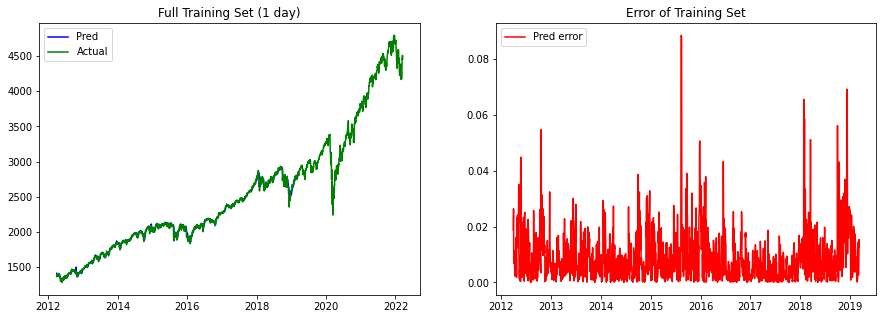

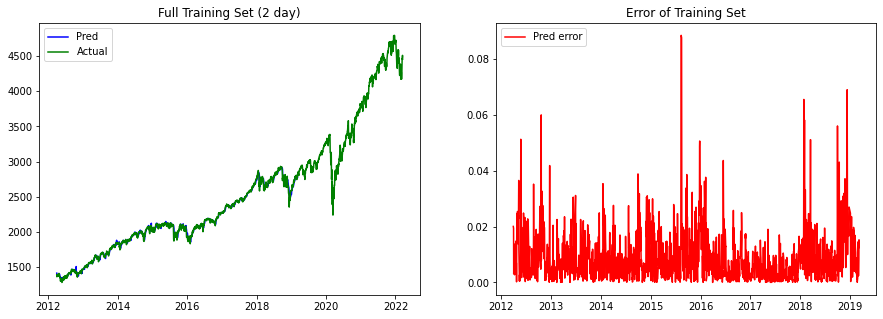

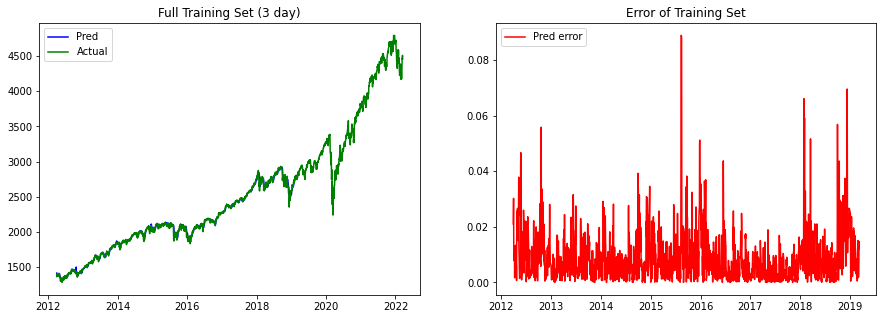

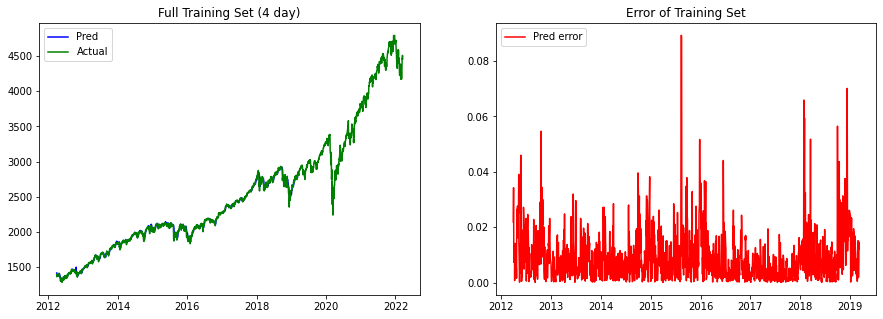

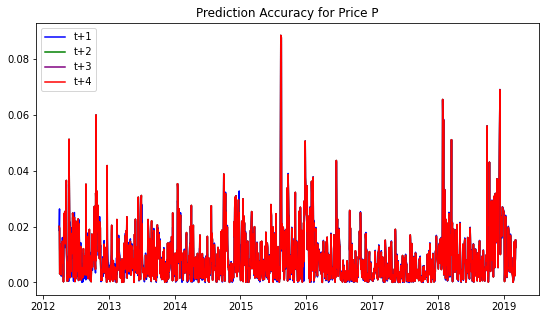

In [184]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_fullTrainingplt = norm.inverse_transform(Y_fullTraining[:, :, 0])
print(date_ft)
import pdb
#pdb.set_trace()
plotNoiselessGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_fullTrainingplt,Y_plt,dateAxis,date_ft,
"Full Training Set (1 day)","Full Training Set (2 day)","Full Training Set (3 day)","Full Training Set (4 day)","Error of Training Set")

plotAccuracy(output_plt1,output_plt2,output_plt3,output_plt4,Y_fullTrainingplt,date_ft )

In [141]:
# Test step
Step 5

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.055485,0.042399,0.591470,-0.922103
2 day,0.044043,0.031264,0.561413,-0.778929
3 day,0.046369,0.034966,0.605743,-0.818331
4 day,0.045337,0.033697,0.596073,-0.805269


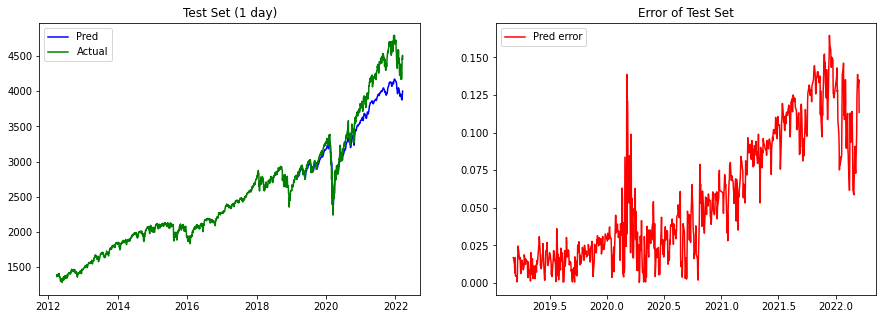

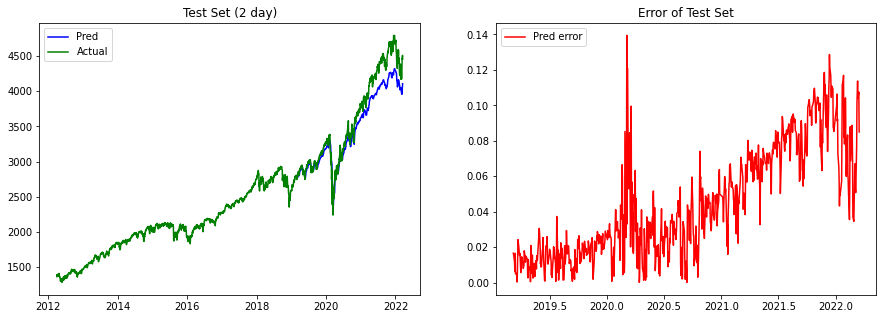

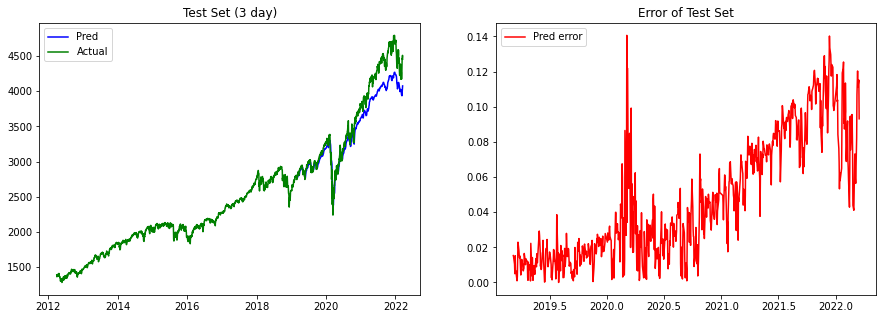

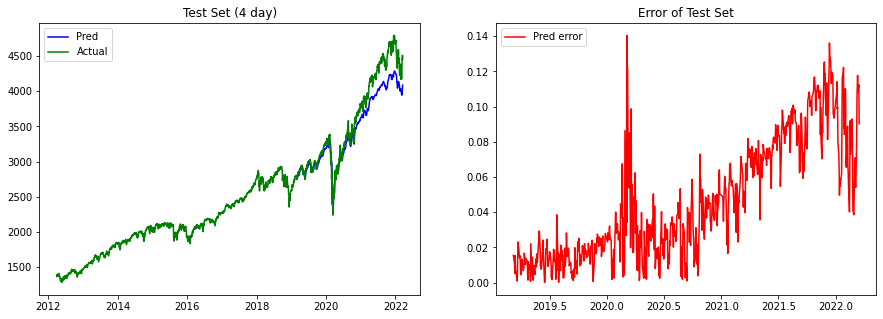

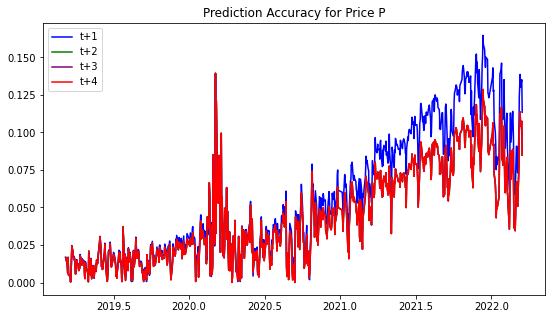

In [176]:
RNN.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

plotNoiselessGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,Y_plt,dateAxis,date_t,
"Test Set (1 day)","Test Set (2 day)","Test Set (3 day)","Test Set (4 day)","Error of Test Set")

plotAccuracy(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,date_t )

In [ ]:
#Step 6

In [ ]:
#Step7

In [ ]:
#step8